# Discovery of Writing Differences - Neural Networks Representation

Capstone project by Tomo Umer

<img src="https://tomoumerdotcom.files.wordpress.com/2022/04/cropped-pho_logo_notext.png" alt="PRAISE DOG" style="width:400px;height:400px;"/>

## Imports

In [1]:
import pandas as pd
import numpy as np
import re
import glob
import plotly.express as px
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import MaxAbsScaler
from copy import deepcopy

import umap
from scipy import spatial
from scipy.cluster.hierarchy import linkage, dendrogram

from joblib import dump, load

## Reading In the Library and Prep for NN

In this part, reading the .pkl file. 

In [2]:
library_select = pd.read_pickle('../data/library_select02.pkl')

In [3]:
library_select.shape

(538, 12)

Next, extract authors, create dictionary to convert authors name to numeric values (for predictions) and add a column with that.

In [4]:
select_authors = list(library_select.sort_values(by='authorcentury')['author'].unique())

authors_to_num = {select_authors[i]: i for i in range(len(select_authors))}
#num_to_authors = {v: k for k, v in authors_to_num.items()}

library_select['author_num'] = library_select['author'].map(authors_to_num)

## Sklearn NN

First round of neural network analysis, using sklearn.

In [5]:
X = library_select[['book_content']]
y = library_select['author_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [6]:
pipe_nn = Pipeline(
    steps = [
        ('vect', TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=(1,2))),
        ('scaler', MaxAbsScaler()),  #this is needed in order to make it converge in a reasonable time!
        ('nn', MLPClassifier(verbose = True,
                             hidden_layer_sizes = (100, 100),
                             #activation = 'relu',
                             #max_iter = 10000,
                             #alpha=0.05
                             ))
    ]
)

In [7]:
# pipe_nn.fit(X_train['book_content'], y_train)
# y_pred = pipe_nn.predict(X_test['book_content'])

# print('accuracy score:', accuracy_score(y_test, y_pred), '\n')
# print('----- confusion matrix ------')
# print(confusion_matrix(y_test, y_pred), '\n')
# print('-------- classification report ---------')
# print(classification_report(y_test, y_pred))

# this below ran for almost 2 hours and didn't finish yet...
pipe_nn.fit(X['book_content'], y)
y_pred = pipe_nn.predict(X['book_content'])

print('accuracy score:', accuracy_score(y, y_pred), '\n')
print('----- confusion matrix ------')
print(confusion_matrix(y, y_pred), '\n')
print('-------- classification report ---------')
print(classification_report(y, y_pred))

Iteration 1, loss = 2.26871212
Iteration 2, loss = 0.20831794
Iteration 3, loss = 0.03829800
Iteration 4, loss = 0.01698789
Iteration 5, loss = 0.01135154
Iteration 6, loss = 0.00823633
Iteration 7, loss = 0.00724374
Iteration 8, loss = 0.00663261
Iteration 9, loss = 0.00568978
Iteration 10, loss = 0.00515580
Iteration 11, loss = 0.00460699
Iteration 12, loss = 0.00442422
Iteration 13, loss = 0.00406795
Iteration 14, loss = 0.00392614
Iteration 15, loss = 0.00353138
Iteration 16, loss = 0.00352007
Iteration 17, loss = 0.00330387
Iteration 18, loss = 0.00318178
Iteration 19, loss = 0.00299044
Iteration 20, loss = 0.00294201
Iteration 21, loss = 0.00291081
Iteration 22, loss = 0.00280704
Iteration 23, loss = 0.00272513
Iteration 24, loss = 0.00265151
Iteration 25, loss = 0.00261037
Iteration 26, loss = 0.00255899
Iteration 27, loss = 0.00254938
Iteration 28, loss = 0.00247662
Iteration 29, loss = 0.00242152
Iteration 30, loss = 0.00241817
Iteration 31, loss = 0.00236151
Iteration 32, los

In [8]:
fig = px.imshow(confusion_matrix(y, pipe_nn.predict(X['book_content'])),
                width=1000,
                height=800,
                text_auto=True,
                labels=dict(x='Predicted Label',
                            y='True Label'),
                            x=select_authors,
                            y=select_authors,
                            color_continuous_scale='Teal'
                            )

fig.update(layout_coloraxis_showscale=False)

fig.show()

## Encoding and lower-dimensional representation of the NN

With a trained model, using embeddings to find similarities between books and authors.

In [9]:
# have to use the regressor because classifiers thinks we're expecting int results, even if we chop it off before final step!
# :2 and layers = 3 if I use two hidden layers with nn; for one, reduce those by 1
encoder = MLPRegressor()
encoder.coefs_ = pipe_nn['nn'].coefs_[:2]
encoder.intercepts_ = pipe_nn['nn'].intercepts_[:2]
encoder.n_layers_ = 3
encoder.out_activation_ = 'relu'

In [10]:
# copy the pipeline
pipe_nn_encoder = deepcopy(pipe_nn)

# remove the classifier
pipe_nn_encoder.steps.pop(2)

# append the new encoder (essentially, it contains all layers minus the final one)
pipe_nn_encoder.steps.append(['enc', encoder])

In [11]:
# now using predict from the encoder to get the 100-dimensional projection of the top six authors
nn_represent = pipe_nn_encoder.predict(library_select['book_content'])

In [12]:
# to save the encoder
# dump(pipe_nn_encoder, '../models/pipe_nn_encoder_01.joblib')
#dump(pipe_nn_encoder, '../models/pipe_nn_encoder_02.joblib')

['../models/pipe_nn_encoder_02.joblib']

Finally, adding to that, the reduced 2D representation using UMAP.

In [13]:
umap_mnist = umap.UMAP()
umap_mnist.fit(nn_represent)

umap_projection = umap_mnist.transform(nn_represent)

In [14]:
# to save the umap representation
# dump(umap_mnist, '../models/umap_mnist_01.joblib')
#dump(umap_mnist, '../models/umap_mnist_02.joblib')

['../models/umap_mnist_02.joblib']

In [15]:
# convert the 100 dimensional vector of neuron weights into dataframe
library_select_represent = pd.DataFrame(nn_represent, columns=[f'dim_{x}' for x in range(100)])

# and also the 2d representation
library_select_proj = pd.DataFrame(umap_projection, columns=[f'proj_{x}' for x in range(2)])

# concatenate together with some info from the original df. at this point, for this notebook won't be needing the book texts anymore
# I'll create a new notebook for NN from a different package
library_select = pd.concat([
    library_select[['id','title','author','authorcentury']],
    library_select_proj.set_index(library_select.index),
    library_select_represent.set_index(library_select.index)],
    axis=1)

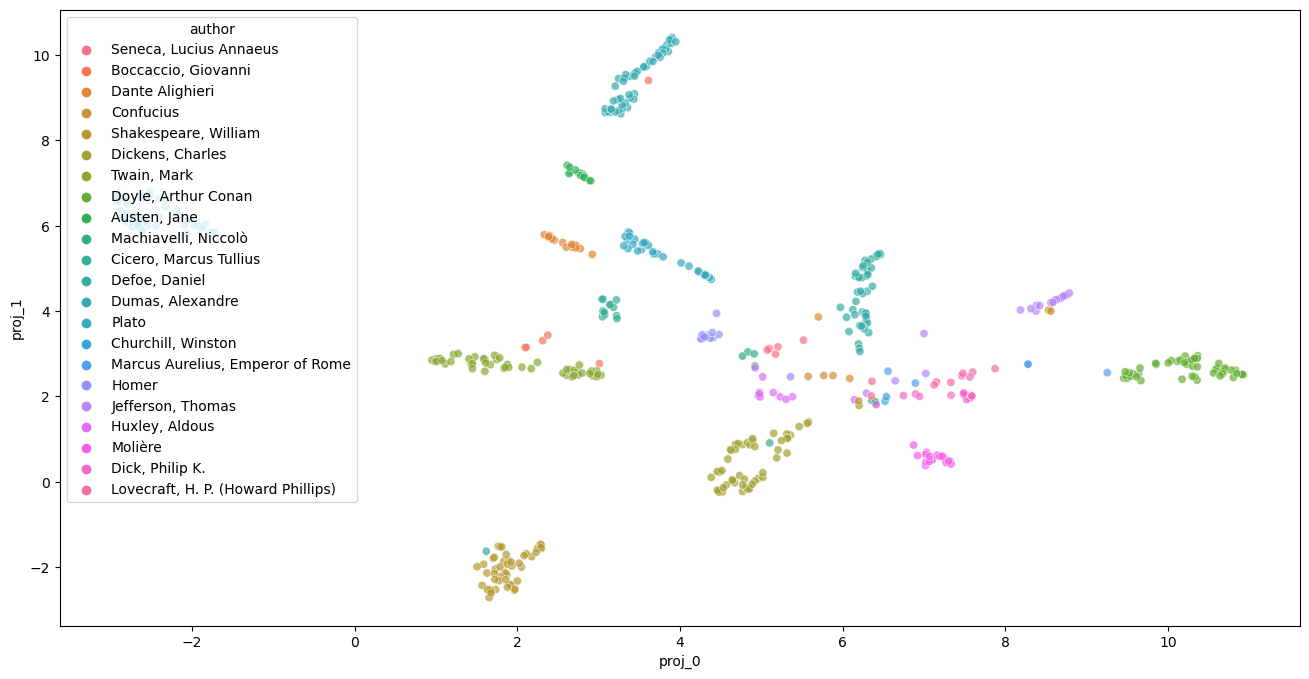

In [16]:
# # old code:
# sns.scatterplot(x=umap_projection[:,0], y=umap_projection[:,1], 
#                 hue = library_select.replace({'author': num_to_authors})['author'].astype('category'),
#                alpha = 0.7);

plt.figure(figsize = (16,8))
sns.scatterplot(data=library_select, x='proj_0', y='proj_1', 
                hue = 'author',
               alpha = 0.7);

In [17]:
library_select['authorcentury'].unique()

array([ 1., 14., 13., -6., 16., 19., 18., 15., -1., -4., 20.,  2., -7.,
       17.])

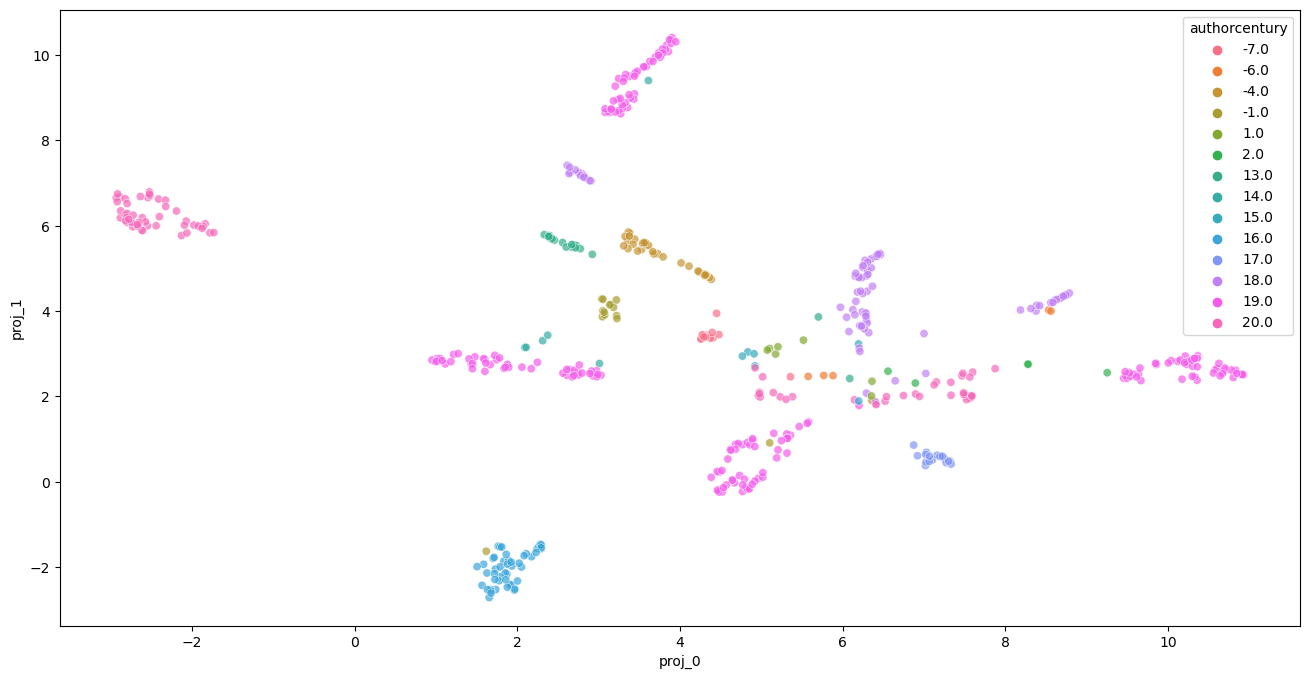

In [18]:
plt.figure(figsize = (16,8))
sns.scatterplot(data=library_select, x='proj_0', y='proj_1', 
                hue = library_select['authorcentury'].astype('category'),
               alpha = 0.7);

In [19]:
# make a copy -- personal note: important to use copy!! otherwise, it's just a view of the original dataframe 
# and that gives warnings in the following two parts
library_2d_dist = library_select[['author', 'proj_0', 'proj_1']].copy()

# calculate the mean point for each author
library_2d_dist[['proj_0_mean', 'proj_1_mean']] = library_2d_dist.groupby('author')[['proj_0', 'proj_1']].transform('mean')

# get the distance between each point and the mean for that author
library_2d_dist['dist_mean'] = np.sqrt((library_2d_dist['proj_0'] - library_2d_dist['proj_0_mean'])**2 + (library_2d_dist['proj_1'] - library_2d_dist['proj_1_mean'])**2)



In [20]:
library_2d_dist

,author,proj_0,proj_1,proj_0_mean,proj_1_mean,dist_mean
1,"Seneca, Lucius Annaeus",6.359278,2.353458,5.539499,2.862678,0.965061
6,"Boccaccio, Giovanni",3.008320,2.769008,2.582992,4.200845,1.493674
21,Dante Alighieri,2.691168,5.552940,2.907257,5.351478,0.295435
32,Dante Alighieri,2.554750,5.607345,2.907257,5.351478,0.435579
43,Dante Alighieri,2.722931,5.535054,2.907257,5.351478,0.260147
...,...,...,...,...,...,...
70047,"Dickens, Charles",4.886846,-0.058703,4.889219,0.472903,0.531611
70069,"Dumas, Alexandre",3.153095,8.731728,3.479299,9.457211,0.795446
70091,"Dickens, Charles",4.770545,-0.078079,4.889219,0.472903,0.563617
70102,"Dickens, Charles",5.017384,0.210327,4.889219,0.472903,0.292186


In [21]:
library_2d_dist['dist_mean'].describe()

count    538.000000
mean       0.630981
std        0.835103
min        0.007788
25%        0.295813
50%        0.495159
75%        0.711659
max        9.610259
Name: dist_mean, dtype: float64

In [22]:
dist2d_mean = library_2d_dist['dist_mean'].mean()

## Cosine Similarity

Another way to look at the produced weights and which ones are similar

Calculating cosine similarity (using dim_0 to dim_99 cols) - for a first attempt, group it by author.

In [23]:
# idea use this to transpose and then see the dist from each book to this point?
library_select_grouped = library_select.drop(columns=['id','title','authorcentury','proj_0','proj_1']).groupby('author').mean()

In [24]:
dists = spatial.distance.pdist(library_select_grouped.values, metric = 'cosine')

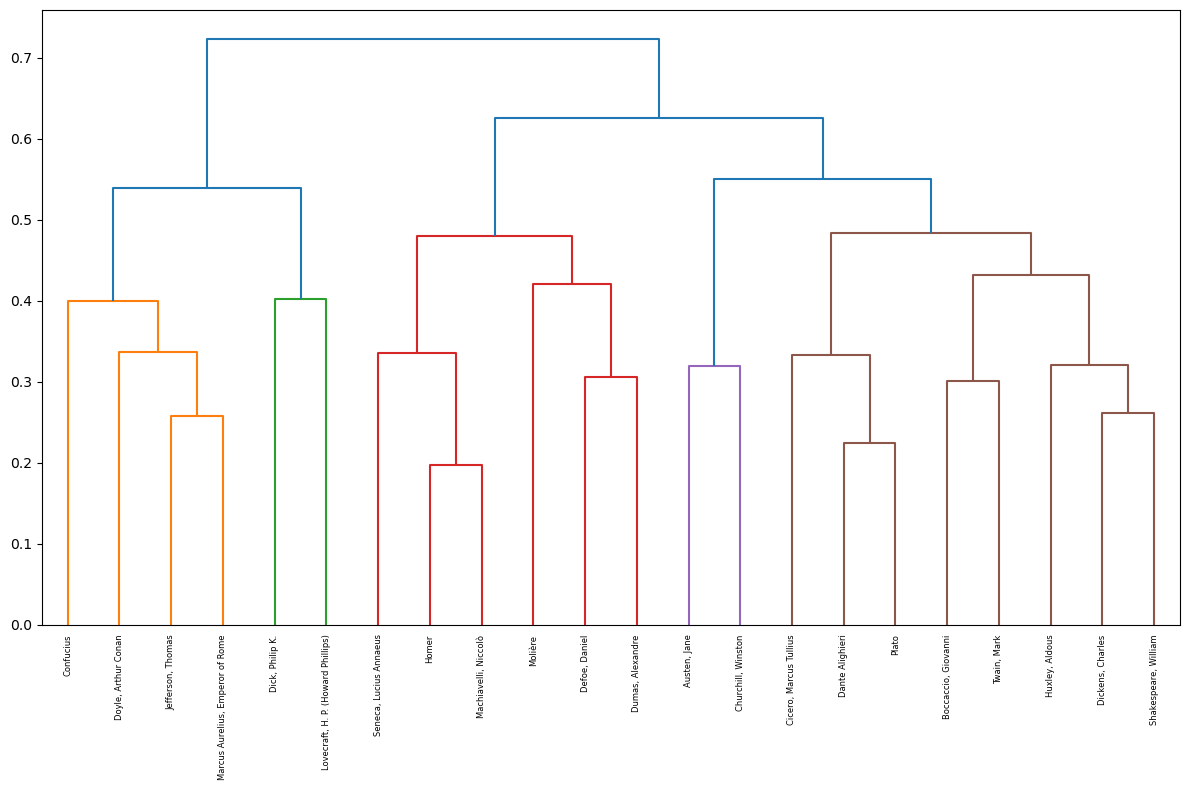

In [25]:
mergings = linkage(dists, method='complete')

plt.figure(figsize = (12,8))
dendrogram(mergings,
           labels = list(library_select_grouped.index),
           leaf_rotation = 90,
           leaf_font_size = 6);

plt.tight_layout()

In [ ]:
# before I realized to use this approach, I first concatenated all the texts in the pandas series which returns an extremely long string
# I then turn that string into a pandas series (the predict requires an iterable object)
# pipe_nn.predict(pd.Series(library_select.loc[library_select['author'] == 0]['book_content'].str.cat()))

## Introducing New Text

This part will ideally be in an app where any text can be uploaded

Here I will test it with two books I've written.

In [ ]:
# if the model was not run above, this is where we load the encoder and the umamp_mnist
#pipe_nn_encoder = load('../models/pipe_nn_encoder_01.joblib') 
#umap_mnist = load('../models/umap_mnist_01.joblib')

In [26]:
newtext = pd.DataFrame()

for book_num, book_name in enumerate(['Lambda', 'Deathway']):
        filepath = f'../data/{book_name} by Tomo Umer.txt'

        with open(filepath, encoding = 'utf-8') as fi:
                book = fi.read()
        
        tmp_text = pd.DataFrame({'id': f'TU{str(book_num).zfill(3)}',
                                 'title': [book_name],
                                 'author': 'Umer, Tomo',
                                 'authorcentury': 21,
                                 'book_content': [book]})

        newtext = pd.concat([newtext, tmp_text], ignore_index = True)

In [27]:
newtext

,id,title,author,authorcentury,book_content
0,TU000,Lambda,"Umer, Tomo",21,Lambda\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...
1,TU001,Deathway,"Umer, Tomo",21,DeathwayIndex\nIntroduction\nMy second novel! ...


As a reminder (to myself), in order to convert the new texts, we only need predict and transform methods

In [28]:
# now using predict from the encoder to get the 100-dimensional projection of new text
nn_represent_newtext = pipe_nn_encoder.predict(newtext['book_content'])

# and its 2d representation using umap
umap_projection_newtext = umap_mnist.transform(nn_represent_newtext)

In [29]:
# and then just like with the authors, convert new texts into a dataframe
# convert the 100 dimensional vector of neuron weights into dataframe
newtxt_represent = pd.DataFrame(nn_represent_newtext, columns=[f'dim_{x}' for x in range(100)])

# and also the 2d representation
newtxt_proj = pd.DataFrame(umap_projection_newtext, columns=[f'proj_{x}' for x in range(2)])

# concatenate together with some info from the original df. at this point, for this notebook won't be needing the book texts anymore
# I'll create a new notebook for NN from a different package
newtext = pd.concat([
    newtext[['id','title','author','authorcentury']],
    newtxt_proj.set_index(newtext.index),
    newtxt_represent.set_index(newtext.index)],
    axis=1)

Then, use the median 0.549409 (or possibly mean 0.721832) value to get a circle around the new texts - to visually represent similar books.

In [30]:
circle_edges = newtext[['proj_0', 'proj_1']].copy()

In [31]:
circle_edges['x0'] = circle_edges['proj_0'] - dist2d_mean
circle_edges['x1'] = circle_edges['proj_0'] + dist2d_mean
circle_edges['y0'] = circle_edges['proj_1'] - dist2d_mean
circle_edges['y1'] = circle_edges['proj_1'] + dist2d_mean

In [32]:
circle_edges

,proj_0,proj_1,x0,x1,y0,y1
0,5.905713,3.898127,5.274732,6.536694,3.267146,4.529108
1,5.724050,1.660762,5.093069,6.355031,1.029781,2.291743


Finally, simply add the new text to the library.

In [33]:
library_newtext = pd.concat([library_select, newtext])

In [34]:
fig = px.scatter(data_frame = library_newtext,
                 x='proj_0',
                 y='proj_1',
                 width=1200,
                 height=800,
                 color= 'author',
                 color_discrete_sequence=px.colors.qualitative.Alphabet, #Dark24
                 hover_data= ['title']
                 )

for i in range(circle_edges.shape[0]):
    fig.add_shape(type='circle',
        xref='x', yref='y',
        x0=circle_edges['x0'][i],
        y0=circle_edges['y0'][i],
        x1=circle_edges['x1'][i],
        y1=circle_edges['y1'][i],
        line_color='LightSeaGreen',
    )


fig.show()

In [35]:
fig = px.scatter(data_frame = library_newtext,
                 x='proj_0',
                 y='proj_1',
                 width=1200,
                 height=800,
                 color= library_newtext['authorcentury'].astype('category'),
                 color_discrete_sequence=px.colors.qualitative.Alphabet, #Dark24
                 hover_data= ['title']
                 )

fig.show()

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_90,dim_91,dim_92,dim_93,dim_94,dim_95,dim_96,dim_97,dim_98,dim_99
1,18.811609,0.000000,4.912124,0.000000,7.514290,3.731085,0.0,0.000000,9.269971,0.0,...,0.0,7.834490,2.857789,13.530958,10.146735,4.404608,0.000000,0.000000,0.000000,0.000000
6,18.051684,10.087243,0.000000,0.000000,8.727279,0.000000,0.0,28.128934,0.000000,0.0,...,0.0,0.000000,8.613489,0.000000,0.000000,0.000000,0.000000,9.179510,22.832225,11.508276
21,30.685600,0.000000,0.000000,0.000000,12.095856,0.000000,0.0,65.835461,0.000000,0.0,...,0.0,2.997994,38.108469,0.000000,54.260673,0.000000,20.431938,0.000000,0.000000,19.708005
32,8.855649,0.000000,18.472201,0.000000,32.096455,0.000000,0.0,38.778183,0.000000,0.0,...,0.0,0.000000,31.984045,8.717551,58.465491,8.572374,0.000000,0.000000,0.000000,15.633381
43,0.000000,2.088360,14.590633,0.000000,32.616219,3.827799,0.0,0.000000,16.459972,0.0,...,0.0,0.000000,14.856931,9.230936,31.181067,0.000000,0.000000,0.000000,35.627109,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70091,59.052362,52.698776,0.000000,15.442651,0.000000,0.000000,0.0,41.234787,6.399877,0.0,...,0.0,0.000000,0.000000,0.000000,19.812291,0.000000,43.821223,0.000000,10.748083,0.000000
70102,34.507914,29.968383,5.114239,9.825061,0.000000,0.000000,0.0,27.905857,8.312298,0.0,...,0.0,0.000000,0.000000,0.000000,10.071068,0.000000,22.913231,0.000000,6.218778,0.000000
70269,39.696628,0.000000,0.000000,4.921284,16.365037,0.000000,0.0,28.855773,21.444675,0.0,...,0.0,0.000000,6.607247,13.843594,28.952792,7.951942,0.000000,9.885558,0.000000,0.000000
0,30.582816,5.559749,0.000000,0.642692,8.568038,0.000000,0.0,20.898959,10.966830,0.0,...,0.0,3.685163,0.000000,7.214759,14.892375,0.998020,0.000000,0.000000,6.239103,4.422324


In [39]:
dists = spatial.distance.pdist(library_newtext.drop(columns=['id', 'title', 'author', 'authorcentury', 'proj_0', 'proj_1']).values, metric = 'cosine')

note: to find out the dist between two authors, need to get the correct index for dist.

for i < j < m (where m = num of authors):

index = m * i + j - ((i + 2) * (i + 1)) // 2

dists[index]

For Lambda, cosine distance:

In [82]:
m = library_newtext.shape[0]
j = m-2

cos_dist = []
titles = []
authors = []

for i in range(j):
    titles.append(library_newtext['title'].iloc[i])
    authors.append(library_newtext['author'].iloc[i])
    cos_dist.append(dists[m * i + j - ((i + 2) * (i + 1)) // 2])

In [83]:
pd.concat([pd.DataFrame({'title':titles}),
           pd.DataFrame({'author':authors}),
           pd.DataFrame({'Deathway':cos_dist})],
           axis=1).sort_values(by='Deathway', ascending=True).head(10)

,title,author,Deathway
382,Savrola: A Tale of the Revolution in Laurania,"Churchill, Winston",0.183769
150,Chapters from My Autobiography,"Twain, Mark",0.183832
537,"Tour through the Eastern Counties of England, ...","Defoe, Daniel",0.191852
31,The Refugees: A Tale of Two Continents,"Doyle, Arthur Conan",0.203798
155,"Dickory Cronke: The Dumb Philosopher, or, Grea...","Defoe, Daniel",0.216073
105,Camille (La Dame aux Camilias),"Dumas, Alexandre",0.218140
300,A New Voyage Round the World by a Course Never...,"Defoe, Daniel",0.221305
289,"Augusta Triumphans: Or, the Way to Make London...","Defoe, Daniel",0.222826
394,"The War of Women, Volume 1","Dumas, Alexandre",0.224304
353,Lord Randolph Churchill,"Churchill, Winston",0.228235


For Deathway, cosine distance:

In [84]:
m = library_newtext.shape[0]
j = m-1

cos_dist = []
titles = []
authors = []

for i in range(j):
    titles.append(library_newtext['title'].iloc[i])
    authors.append(library_newtext['author'].iloc[i])
    cos_dist.append(dists[m * i + j - ((i + 2) * (i + 1)) // 2])

In [85]:
# Lambda is of course the most similar ... if wanted, simply do a .drop(538) on all 3 dataframes
pd.concat([pd.DataFrame({'title':titles}),
           pd.DataFrame({'author':authors}),
           pd.DataFrame({'Deathway':cos_dist})],
           axis=1).sort_values(by='Deathway', ascending=True).head(10)

,title,author,Deathway
538,Lambda,"Umer, Tomo",0.039126
434,The Mystery of Edwin Drood,"Dickens, Charles",0.147057
524,"Sketches by Boz, Illustrative of Every-Day Lif...","Dickens, Charles",0.147214
150,Chapters from My Autobiography,"Twain, Mark",0.150826
528,The Uncommercial Traveller,"Dickens, Charles",0.152925
200,"The Letters of Charles Dickens. Vol. 2, 1857-1870","Dickens, Charles",0.176101
382,Savrola: A Tale of the Revolution in Laurania,"Churchill, Winston",0.180540
199,"The Letters of Charles Dickens. Vol. 1, 1833-1856","Dickens, Charles",0.185521
535,Nicholas Nickleby,"Dickens, Charles",0.201778
514,George Silverman's Explanation,"Dickens, Charles",0.204754
